In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [24]:
import json
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import polars as pl

from src.log_config import configure_logging
from src.models.data_loader import create_dataloaders
from src.models.data_preparation import (
    expand_feature_list,
    load_data_from_database,
    prepare_data,
)
from src.models.main_config import RANDOM_SEED
from src.models.utils import load_model
from src.plots.model_performance_per_participant import (
    analyze_per_participant,
    plot_feature_accuracy_comparison,
    plot_participant_accuracy_comparison,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado", "filelock"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials

polars.config.Config

In [ ]:
results = {}


In [11]:
feature_lists = [
    # ["eda_raw"],
    ["heart_rate"],
    # ["pupil"],
    ["eda_raw", "pupil"],
    # ["eda_raw", "heart_rate"],
    # ["eda_raw", "heart_rate", "pupil"],
    ["face"],
    ["eeg"],
]
feature_lists = expand_feature_list(feature_lists)
feature_list = feature_lists[0]
feature_list_str = "_".join(feature_list)

In [ ]:
# Load data from database
df = load_data_from_database(feature_list=feature_list)

# Load model
json_path = Path(f"results/experiment_{feature_list_str}/results.json")
dictionary = json.loads(json_path.read_text())
model_path = Path(dictionary["overall_best"]["model_path"].replace("\\", "/"))

model, feature_list, sample_duration_ms, intervals, label_mapping, offsets_ms = (
    load_model(model_path, device="cpu")
)

# Prepare data
X_train, y_train, X_val, y_val, X_train_val, y_train_val, X_test, y_test = prepare_data(
    df=df,
    feature_list=feature_list,
    sample_duration_ms=sample_duration_ms,
    intervals=intervals,
    label_mapping=label_mapping,
    offsets_ms=offsets_ms,
    random_seed=RANDOM_SEED,
)
test_groups = prepare_data(
    df=df,
    feature_list=feature_list,
    sample_duration_ms=sample_duration_ms,
    intervals=intervals,
    label_mapping=label_mapping,
    offsets_ms=offsets_ms,
    random_seed=RANDOM_SEED,
    only_return_test_groups=True,
)
_, test_loader = create_dataloaders(
    X_train_val, y_train_val, X_test, y_test, batch_size=64
)
result_df = analyze_per_participant(
    model,
    test_loader,
    test_groups,
    threshold=0.50,
)
results[feature_list_str] = result_df

02:03:10 | INFO    | utils | Using device: cpu
02:03:10 | INFO    | utils | Loaded MLP model with test accuracy 0.53 to cpu
02:03:10 | INFO    | utils | Input shape: (70, 1) | Features: ['heart_rate'] | Sample duration: 7000 ms
02:03:10 | DEBUG   | utils | Intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
02:03:10 | DEBUG   | utils | Label mapping: {'increases': 0, 'plateaus': 0, 'decreases': 1}
02:03:10 | DEBUG   | utils | Offset ms: {'increases': 0, 'plateaus': 5000, 'decreases': 1000}
02:03:10 | DEBUG   | sample_creation | Removed 749 samples with less than 69 data points
02:03:11 | DEBUG   | data_preparation | Preparing data with sample duration 7000 ms and random seed 42
02:03:11 | DEBUG   | data_preparation | Samples are based on intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
02:03:11 | DEBUG   | data_preparatio

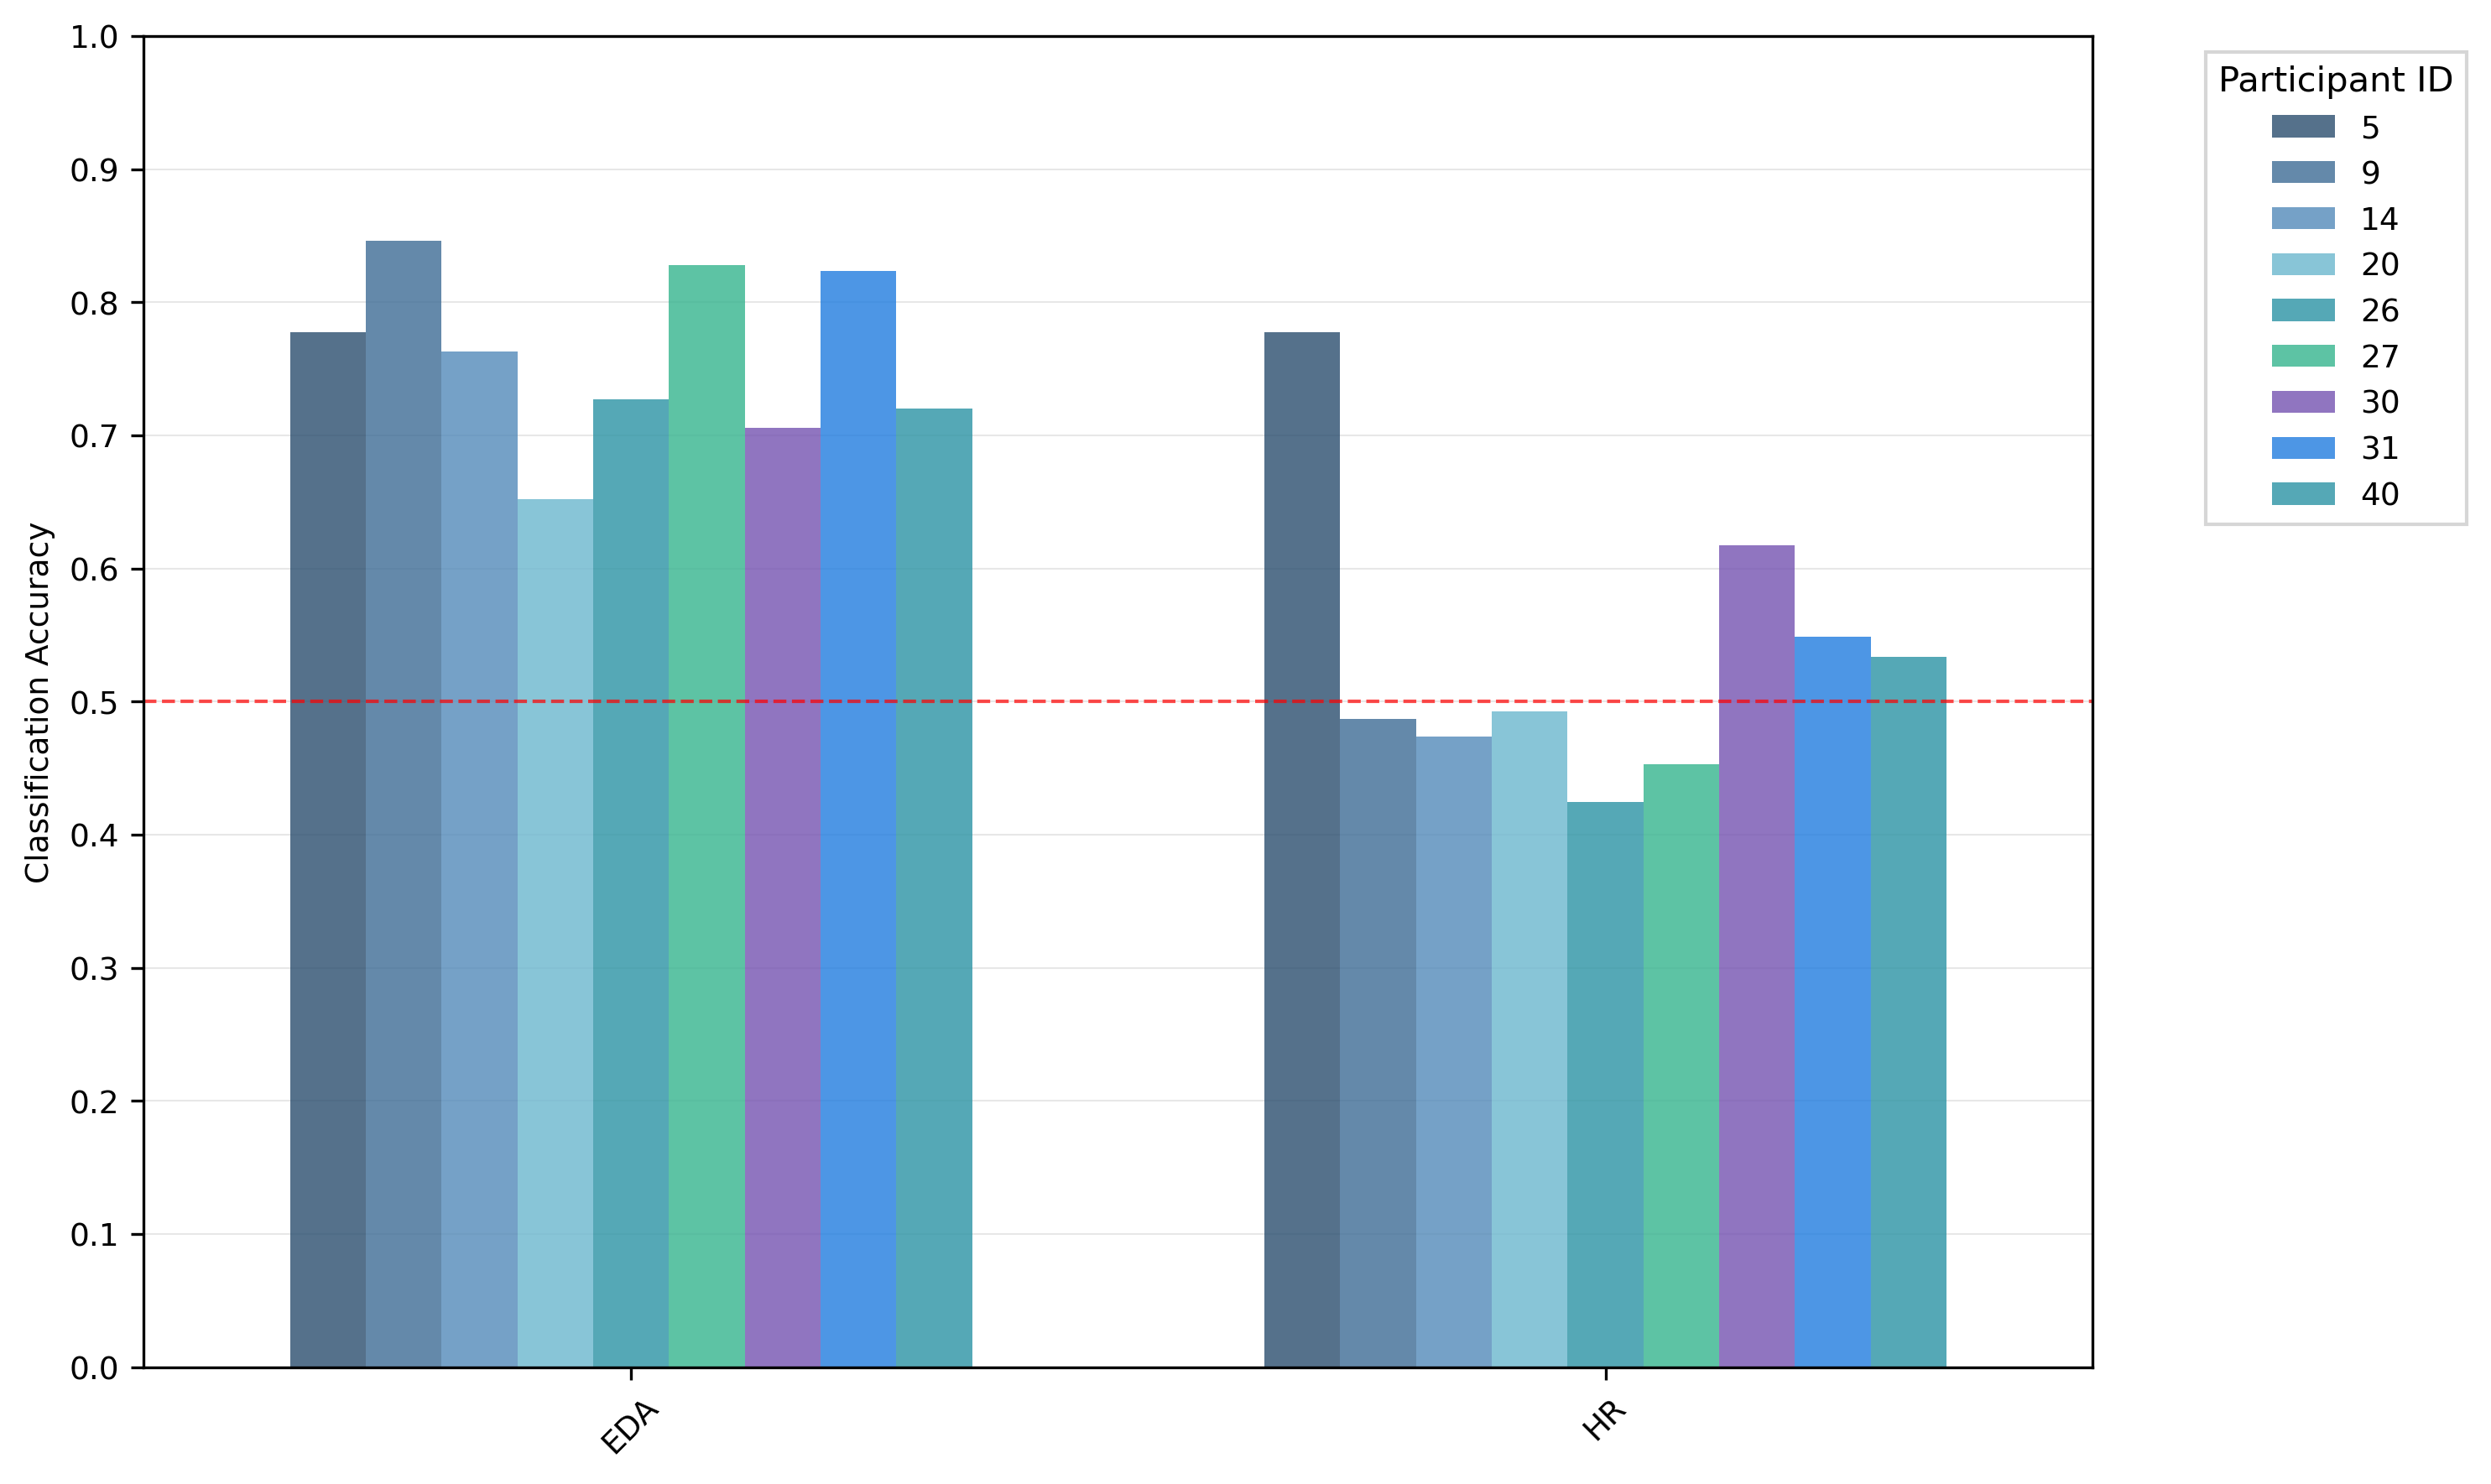

In [30]:
feature_set_acc, _ = plot_feature_accuracy_comparison(results, figsize=(10, 6))
plt.show()

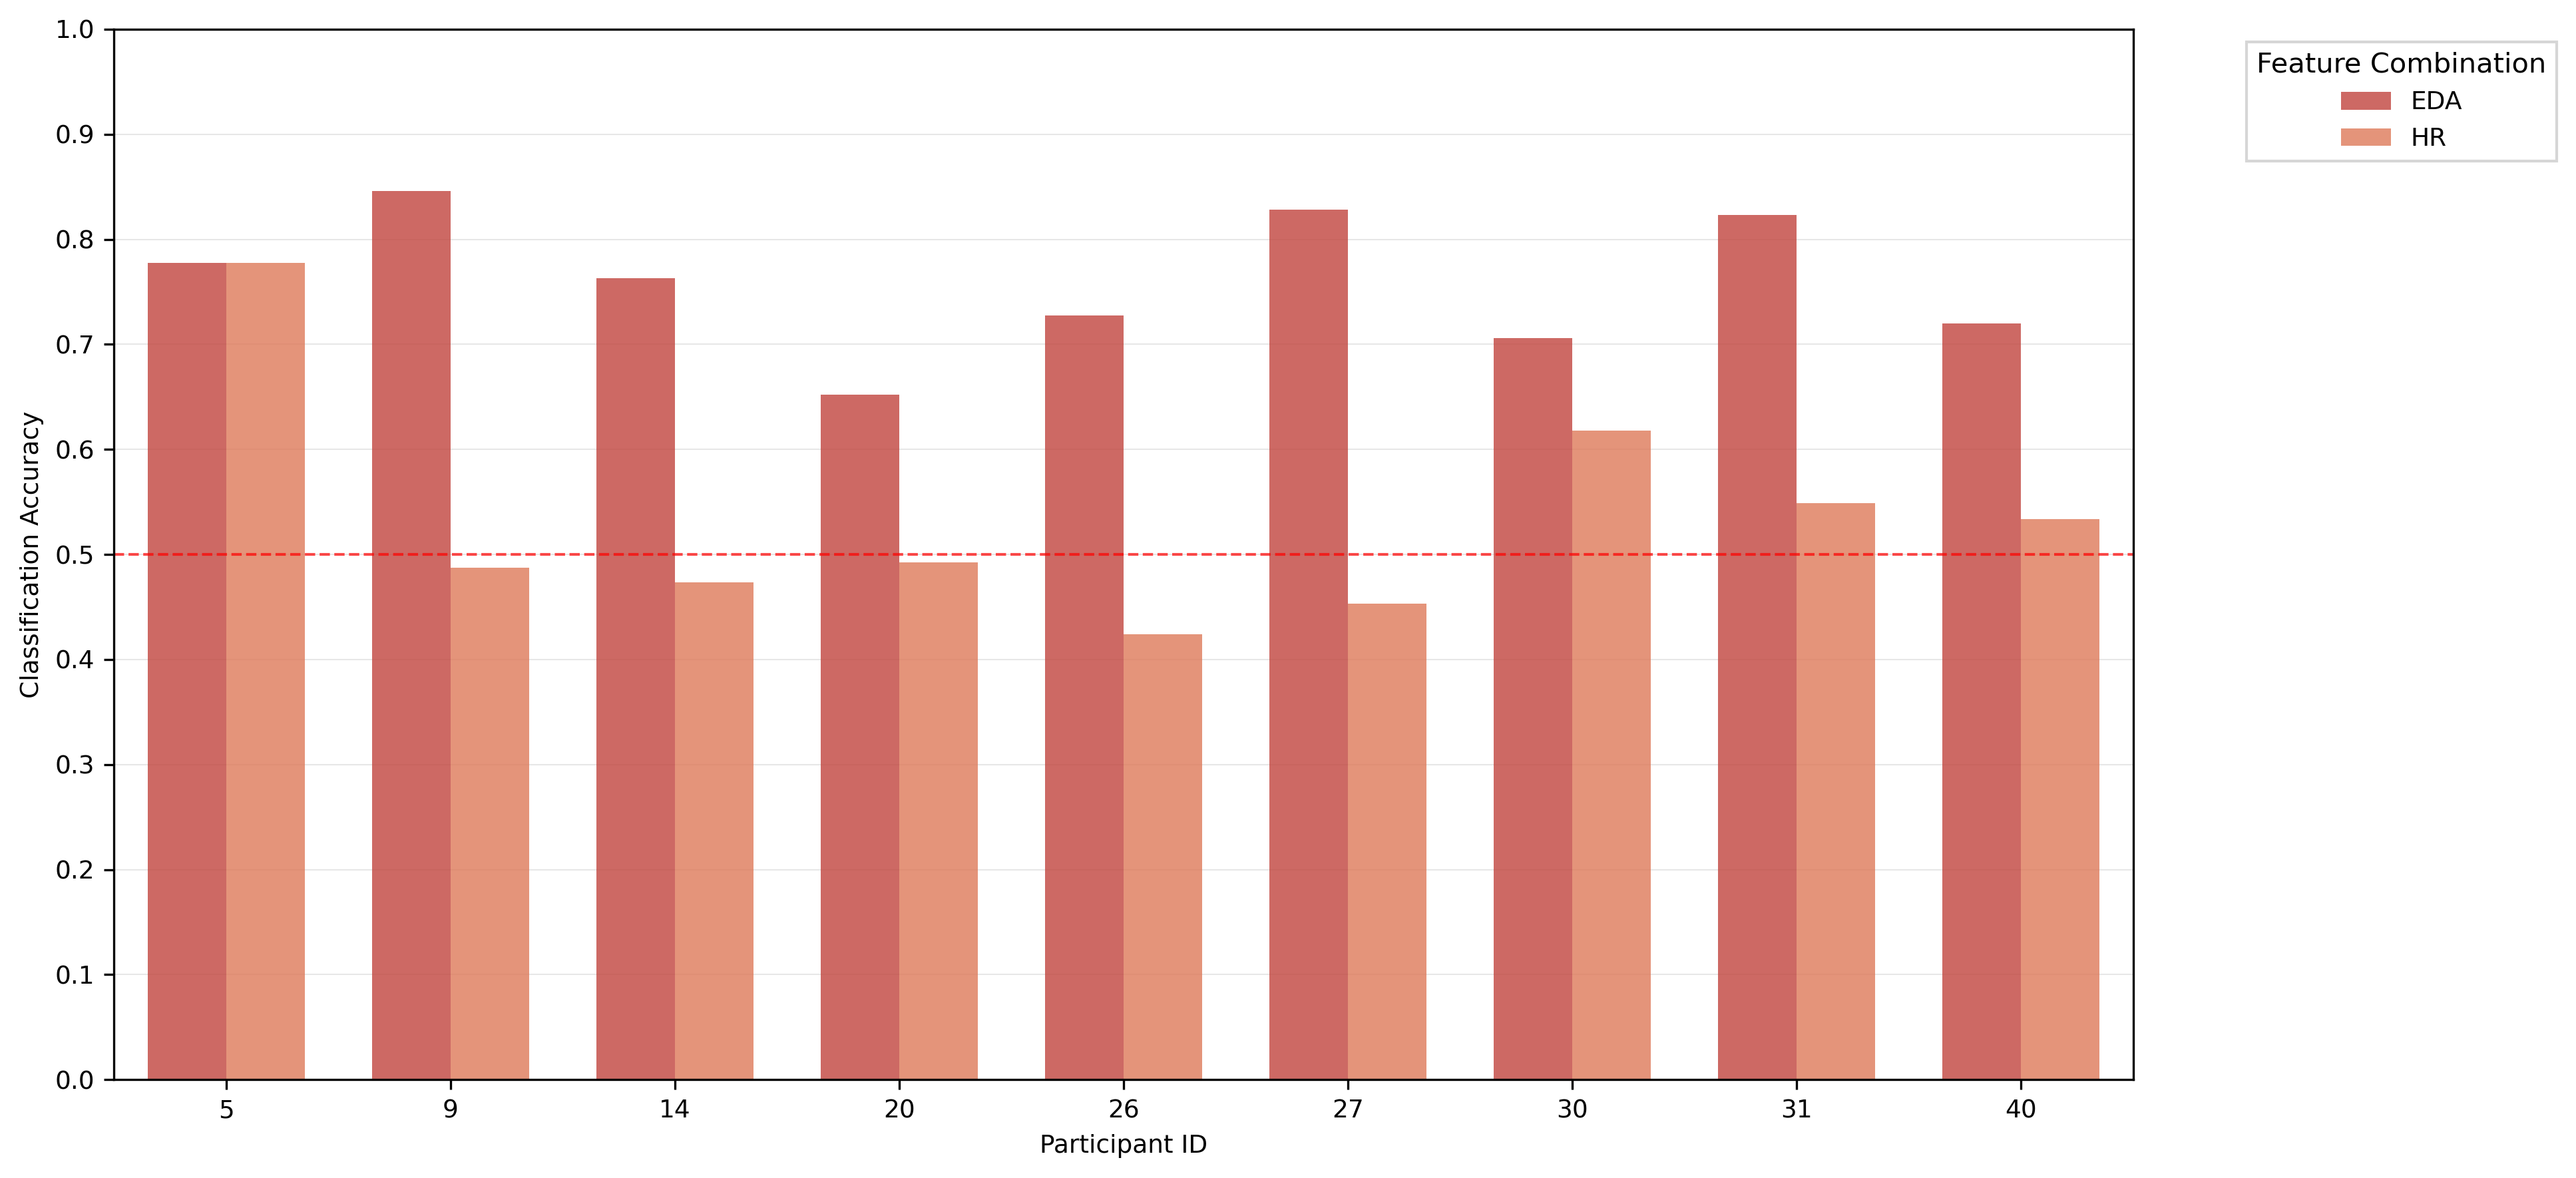

In [29]:
feature_set_acc_by_participant, _ = plot_participant_accuracy_comparison(
    results, figsize=(13, 6)
)
plt.show()